In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, ops
from pathlib import Path
from typing import List, Dict, Tuple
from collections import defaultdict
from matplotlib import patches, text, patheffects
from sklearn.metrics import classification_report
from PIL import Image

try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu118
0.16.0+cu118


# Classification Code

## Data Preprocessing

### Creating train and test transforms

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(100,100)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,0,0],std=[1,1,1],inplace=True)
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(100,100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0,0,0],std=[1,1,1],inplace=True)
])

### Create Dataset from the data

In [5]:
data_dir = Path("/content/drive/MyDrive/data/WCEBleedGen")

train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_dataset = datasets.ImageFolder(
    root = train_dir,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=test_transforms
)

train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 2104
     Root location: /content/drive/MyDrive/data/WCEBleedGen/train
     StandardTransform
 Transform: Compose(
                Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ),
 Dataset ImageFolder
     Number of datapoints: 524
     Root location: /content/drive/MyDrive/data/WCEBleedGen/test
     StandardTransform
 Transform: Compose(
                Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ))

In [6]:
train_dataset.class_to_idx

{'bleeding': 0, 'non-bleeding': 1}

In [7]:
train_img, train_label = train_dataset[0][0], train_dataset[0][1]
print(f"Image tensor:\n{train_img}")
print(f"Image shape: {train_img.shape}")
print(f"Image datatype: {train_img.dtype}")
print(f"Image label: {train_label}")
print(f"Label datatype: {type(train_label)}")

Image tensor:
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.4314, 0.4196, 0.4196],
         [0.0000, 0.0000, 0.0000,  ..., 0.4706, 0.4667, 0.4471],
         [0.0000, 0.0000, 0.0000,  ..., 0.4745, 0.4784, 0.4667],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.4431, 0.4314, 0.4235],
         [0.0000, 0.0000, 0.0000,  ..., 0.4157, 0.4039, 0.3961],
         [0.0000, 0.0000, 0.0000,  ..., 0.3804, 0.3804, 0.3922]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.3294, 0.3176, 0.3176],
         [0.0000, 0.0000, 0.0000,  ..., 0.3569, 0.3529, 0.3373],
         [0.0000, 0.0000, 0.0000,  ..., 0.3569, 0.3608, 0.3490],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3098, 0.3020, 0.2980],
         [0.0000, 0.0000, 0.0000,  ..., 0.2980, 0.2902, 0.2824],
         [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2667, 0.2745]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.2235, 0.2118, 0.2196],
         [0.0000, 0.0000, 0.0000,  ..., 0.2431, 0.2431, 0.2314],
         [0.0000, 0.0000, 0.0000,  ..., 0.23

In [8]:
test_img, test_label = test_dataset[0][0], test_dataset[0][1]
print(f"Image tensor:\n{test_img}")
print(f"Image shape: {test_img.shape}")
print(f"Image datatype: {test_img.dtype}")
print(f"Image label: {test_label}")
print(f"Label datatype: {type(test_label)}")

Image tensor:
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.00

In [9]:
class_name = train_dataset.classes
class_name

['bleeding', 'non-bleeding']

(-0.5, 99.5, 99.5, -0.5)

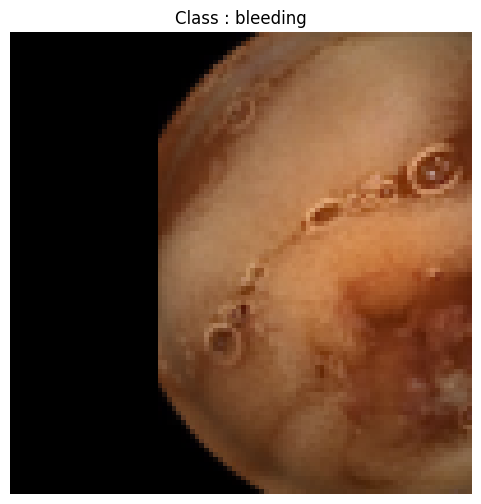

In [10]:
import matplotlib.pyplot as plt

permute_img = train_img.permute(1,2,0)
fig = plt.figure(figsize=(6,6))

plt.imshow(permute_img)
plt.title(f"Class : {class_name[train_label]}")
plt.axis(False)

### Create DataLoader from the dataset

In [11]:
import os

BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_dataset,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa8c4ff8130>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa9a82158d0>)

In [12]:
batch_img, batch_label = next(iter(train_dataloader))
batch_img.shape, batch_label.shape

(torch.Size([128, 3, 100, 100]), torch.Size([128]))

In [13]:
batch_img

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [14]:
batch_label

tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1])

### Device Agnostics

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Create Model Class

In [16]:
class WCEBleedGen(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    self.layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,padding='same'),
        nn.BatchNorm2d(num_features=8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding='same'),
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer_3 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding='same'),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.layer_4 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=32*12*12,out_features=32),
        nn.Linear(in_features=32, out_features=2)
    )

  def forward(self, x : torch.Tensor) -> torch.Tensor:

    return self.layer_4(self.layer_3(self.layer_2(self.layer_1(x))))


### Checking forwards pass

In [17]:
model = WCEBleedGen().to(device)

model.eval()
with torch.inference_mode():
  print(model(batch_img.to(device)).shape)

torch.Size([128, 2])


In [18]:
summary(model, input_size=[1, 3, 100, 100]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
WCEBleedGen                              [1, 2]                    --
├─Sequential: 1-1                        [1, 8, 50, 50]            --
│    └─Conv2d: 2-1                       [1, 8, 100, 100]          224
│    └─BatchNorm2d: 2-2                  [1, 8, 100, 100]          16
│    └─ReLU: 2-3                         [1, 8, 100, 100]          --
│    └─MaxPool2d: 2-4                    [1, 8, 50, 50]            --
├─Sequential: 1-2                        [1, 16, 25, 25]           --
│    └─Conv2d: 2-5                       [1, 16, 50, 50]           1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 50, 50]           32
│    └─ReLU: 2-7                         [1, 16, 50, 50]           --
│    └─MaxPool2d: 2-8                    [1, 16, 25, 25]           --
├─Sequential: 1-3                        [1, 32, 12, 12]           --
│    └─Conv2d: 2-9                       [1, 32, 25, 25]           4,640
│    └─B

## Train and test functions

### Loss Function and Optimiser

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimiser,step_size=1,gamma=0.9)

### Training Function

In [20]:
def train_step(train_dataloader : torch.utils.data.DataLoader,
          model : nn.Module,
          loss_fn : nn.Module,
          optimiser : torch.optim.Optimizer,
          ):

  # Put the model in training mode
  model.train()

  # metrics to calculate
  training_loss = 0
  training_accuracy = 0

  for batch, (X,y) in enumerate(train_dataloader):

    # put data on correct device
    X = X.to(device)
    y = y.to(device)

    # make a prediction
    y_pred = model(X) #Logits
    y_pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    # Calculate loss and accuracy
    loss = loss_fn(y_pred, y)
    training_loss += loss
    training_accuracy += (y==y_pred_label).sum().item()/len(y)

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  # Calculate training loss and accuracy per batch
  training_loss/=len(train_dataloader)
  training_accuracy/=len(train_dataloader)

  return training_loss.item(), training_accuracy

### Testing Function

In [21]:
def test_step(test_dataloader : torch.utils.data.DataLoader,
          model : nn.Module,
          loss_fn : nn.Module,
          ):

  #Put the model in evaluation mode
  model.eval()

  test_loss = 0
  test_accuracy = 0

  with torch.inference_mode():

    for batch, (X,y) in enumerate(test_dataloader):

      # Put the data on right device
      X = X.to(device)
      y = y.to(device)

      test_pred = model(X) # Logits
      test_pred_label = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)

      test_loss += loss_fn(test_pred, y)
      test_accuracy += (test_pred_label==y).sum().item()/len(y)

    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)

  return test_loss.item(), test_accuracy

### Overall Train function

In [22]:
from tqdm.auto import tqdm
from collections import defaultdict

def train(model : nn.Module,
          train_dataloader : torch.utils.data.DataLoader,
          test_dataloader : torch.utils.data.DataLoader,
          loss_fn : nn.Module,
          optimiser : torch.optim.Optimizer,
          epochs : int = 5
          ):

  result = defaultdict(list)

  for epoch in tqdm(range(epochs)):

    # train and test step
    train_loss, train_acc = train_step(train_dataloader=train_dataloader,
                                       model = model,
                                       loss_fn = loss_fn,
                                       optimiser = optimiser)
    test_loss, test_acc = test_step(test_dataloader=test_dataloader,
                                    model = model,
                                    loss_fn = loss_fn)

    # Store the results
    result['train_loss'].append(train_loss)
    result['test_loss'].append(test_loss)
    result['train_accuracy'].append(train_acc)
    result['test_accuracy'].append(test_acc)

    scheduler.step()

    # print what's happening
    print(f"Epoch : {epoch} | training loss = {train_loss} | test loss = {test_loss} | training accuracy = {train_acc} | test accuracy = {test_acc}")

  return result

## Actual Training

In [ ]:
from timeit import default_timer as timer

epochs = 50

start_time = timer()
result = train(model = model,
               train_dataloader = train_dataloader,
               test_dataloader = test_dataloader,
               loss_fn = loss_fn,
               optimiser = optimiser,
               epochs = epochs
               )

end_time = timer()
print(f"Total time taken for training : {end_time - start_time} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch : 0 | training loss = 0.5255707502365112 | test loss = 0.6013131737709045 | training accuracy = 0.7448792016806722 | test accuracy = 0.8171875
Epoch : 1 | training loss = 0.42216071486473083 | test loss = 0.2880120277404785 | training accuracy = 0.8045561974789917 | test accuracy = 0.884375
Epoch : 2 | training loss = 0.37263134121894836 | test loss = 0.2500724196434021 | training accuracy = 0.8287158613445378 | test accuracy = 0.8875
Epoch : 3 | training loss = 0.3733217716217041 | test loss = 0.19676610827445984 | training accuracy = 0.8321297268907564 | test accuracy = 0.9203125
Epoch : 4 | training loss = 0.321058064699173 | test loss = 0.16056588292121887 | training accuracy = 0.8590467436974789 | test accuracy = 0.946875
Epoch : 5 | training loss = 0.2812783718109131 | test loss = 0.15565980970859528 | training accuracy = 0.8807773109243698 | test accuracy = 0.9390625
Epoch : 6 | training loss = 0.31061121821403503 | test loss = 0.17359861731529236 | training accuracy = 0.8

In [ ]:
result

defaultdict(list,
            {'train_loss': [0.5255707502365112,
              0.42216071486473083,
              0.37263134121894836,
              0.3733217716217041,
              0.321058064699173,
              0.2812783718109131,
              0.31061121821403503,
              0.2748605012893677,
              0.2582399547100067,
              0.2375681847333908,
              0.2579493224620819,
              0.25625133514404297,
              0.2360897660255432,
              0.23933152854442596,
              0.2243373990058899,
              0.20658349990844727,
              0.24833402037620544,
              0.22419701516628265,
              0.20966319739818573,
              0.21170832216739655,
              0.17566877603530884,
              0.1875704824924469,
              0.18786275386810303,
              0.20278064906597137,
              0.17390280961990356,
              0.18153686821460724,
              0.1725974977016449,
              0.17627033591270447,
 

## Plotting Results

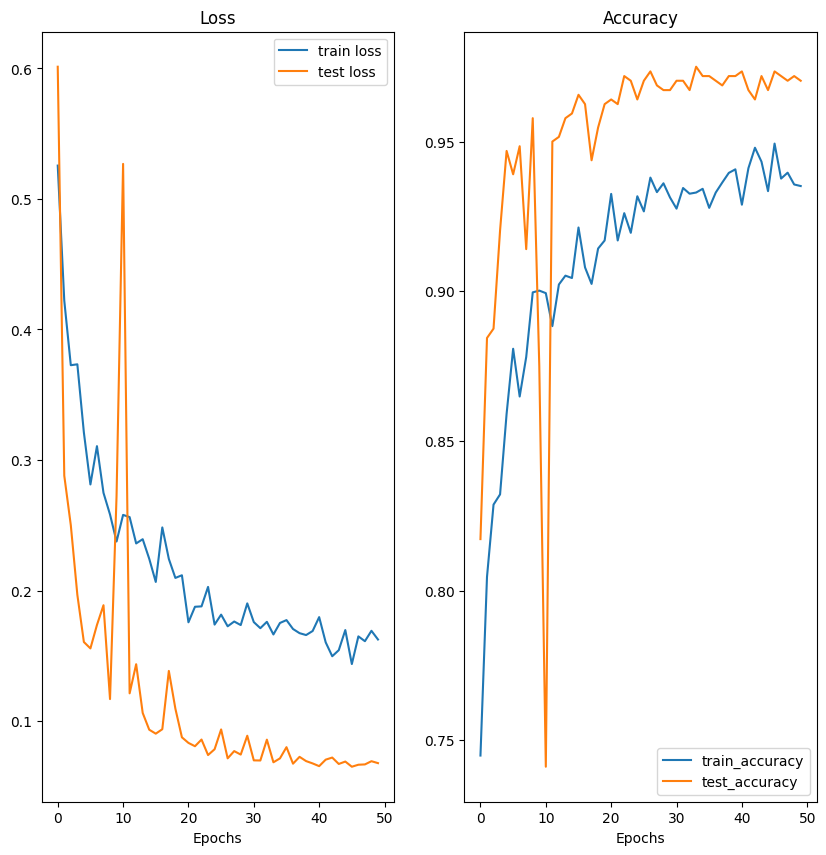

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), result['train_loss'], label='train loss')
plt.plot(range(epochs), result['test_loss'], label='test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), result['train_accuracy'], label='train_accuracy')
plt.plot(range(epochs), result['test_accuracy'], label='test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();


### Save Classification Model Parameters

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/data/WCEBleedGen/Classification Model Parameters")

### Loading Classification Model Parameters

In [23]:
model.load_state_dict(torch.load("/content/drive/MyDrive/data/WCEBleedGen/Classification Model Parameters"))

<All keys matched successfully>

## Classification Metrics

In [24]:
y_pred = []
y_true = []

model.eval()
with torch.inference_mode():

  for images, labels in test_dataset:

    y_pred_logits = model(images.unsqueeze(dim=0).to(device))
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)

    y_pred.append(y_pred_labels.item())
    y_true.append(labels)


print(classification_report(y_pred = y_pred, y_true = y_true))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       262
           1       0.97      0.96      0.96       262

    accuracy                           0.96       524
   macro avg       0.96      0.96      0.96       524
weighted avg       0.96      0.96      0.96       524



## Classification Results on Validation set

### Test 1 Images

In [25]:
validation_test_1_path = Path("/content/drive/MyDrive/Object detection data/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 1")
validation_test_1_images = list(validation_test_1_path.glob("*.png"))

len(validation_test_1_images)

49

In [26]:
validation_test_1_images[0].stem

'A0008'

In [27]:
idx_to_class = {}
for key, val in train_dataset.class_to_idx.items():

  idx_to_class[val] = key

idx_to_class

{0: 'bleeding', 1: 'non-bleeding'}

In [28]:
validation_transform = transforms.Compose([transforms.Resize(size=(100,100)),
                                           transforms.ToTensor()])

test_1_results = defaultdict(list)

model.eval()
with torch.inference_mode():
  for image in validation_test_1_images:

    test_1_results['Image name'].append(image.stem)

    img = Image.open(image)
    transformed_img = validation_transform(img).unsqueeze(dim=0).to(device)

    pred_label = torch.argmax(torch.softmax(model(transformed_img), dim=1), dim=1).item()
    test_1_results['Predicted Class label'].append(pred_label)

test_1_results_df = pd.DataFrame.from_dict(test_1_results)
test_1_results_df['Predicted Class label'] = test_1_results_df['Predicted Class label'].map(idx_to_class)
test_1_results_df

,Image name,Predicted Class label
0,A0008,non-bleeding
1,A0005,non-bleeding
2,A0004,non-bleeding
3,A0007,non-bleeding
4,A0010,non-bleeding
5,A0012,non-bleeding
6,A0013,non-bleeding
7,A0016,non-bleeding
8,A0002,bleeding
9,A0001,non-bleeding


### Test 2 Images

In [29]:
validation_test_2_path = Path("/content/drive/MyDrive/Object detection data/Auto-WCEBleedGen Challenge Test Dataset/Test Dataset 2")
validation_test_2_images = list(validation_test_2_path.glob("*.png"))

len(validation_test_2_images)

515

In [30]:
test_2_results = defaultdict(list)

model.eval()
with torch.inference_mode():
  for image in validation_test_2_images:

    test_2_results['Image name'].append(image.stem)

    img = Image.open(image)
    transformed_img = validation_transform(img).unsqueeze(dim=0).to(device)

    pred_label = torch.argmax(torch.softmax(model(transformed_img), dim=1), dim=1).item()
    test_2_results['Predicted Class label'].append(pred_label)

test_2_results_df = pd.DataFrame.from_dict(test_2_results)
test_2_results_df['Predicted Class label'] = test_2_results_df['Predicted Class label'].map(idx_to_class)
test_2_results_df

,Image name,Predicted Class label
0,A0052,non-bleeding
1,A0051,non-bleeding
2,A0055,non-bleeding
3,A0054,non-bleeding
4,A0056,non-bleeding
...,...,...
510,A0556,non-bleeding
511,A0557,non-bleeding
512,A0559,non-bleeding
513,A0560,non-bleeding


## Create Excel files

In [ ]:
test_1_results_df.to_excel(excel_writer="/content/drive/MyDrive/Object detection data/Auto-WCEBleedGen Challenge Test Dataset/Test 1 Dataset.xlsx")
test_2_results_df.to_excel(excel_writer="/content/drive/MyDrive/Object detection data/Auto-WCEBleedGen Challenge Test Dataset/Test 2 Dataset.xlsx")

# Object Detection Code

### Custom Dataset Class for the Detection Dataset

In [31]:
import re
import numpy as np

from PIL import Image
from pathlib import Path

def numericalSort(value):

  numbers = re.compile(r'(\d+)')
  parts = numbers.split(str(value))
  parts[1::2] = map(int, parts[1::2])
  return parts

transform = transforms.Compose([transforms.ToTensor()])

class BleedingRegionDataset(Dataset):

  """
  Custom Dataset Creator for Bleeding Region detection dataset
  """

  def __init__(self, root_dir : str, bbox_dir : str, transforms = None):

    """
    Arguments :
      root_dir : Path where all the images are stored
      bbox_dir : Path where all the bounding box .txt files are stored
      transforms (optional) : transform to be applied on a sample.

    Returns :
      None
    """

    self.sorted_bleeding_images = sorted(list(Path(root_dir).glob("*.png")), key=numericalSort)
    self.sorted_bleeding_bboxes = sorted(list(Path(bbox_dir).glob("*.txt")), key=numericalSort)
    self.transforms = transforms

  def __len__(self):

    return len(self.sorted_bleeding_images)

  def rearrange_bbox(self, path : pathlib.PosixPath):

    with open(path) as f:
      output = np.array([int(number) for number in f.readlines()[0].split()]).reshape((-1,4))

    return output

  def __getitem__(self, index):

    image_path = self.sorted_bleeding_images[index]
    img_tensor = transform(Image.open(image_path))

    label = {}
    label["boxes"] = torch.FloatTensor(self.rearrange_bbox(self.sorted_bleeding_bboxes[index]))
    label["labels"] = torch.ones(size=[label["boxes"].shape[0]], dtype = torch.int64)

    return img_tensor, label


### Datasets

In [32]:
train_images_dir = "/content/drive/MyDrive/Object detection data/WCEBleedGen/train/Images"
test_images_dir = "/content/drive/MyDrive/Object detection data/WCEBleedGen/test/Images"

train_bboxes_dir = "/content/drive/MyDrive/Object detection data/WCEBleedGen/train/Bounding Boxes"
test_bboxes_dir = "/content/drive/MyDrive/Object detection data/WCEBleedGen/test/Bounding Boxes"

train_object_detection_data = BleedingRegionDataset(root_dir=train_images_dir,
                                                    bbox_dir=train_bboxes_dir)

test_object_detection_data = BleedingRegionDataset(root_dir=test_images_dir,
                                                   bbox_dir=test_bboxes_dir)

train_object_detection_data, test_object_detection_data

(<__main__.BleedingRegionDataset at 0x7fa8c1d24310>,
 <__main__.BleedingRegionDataset at 0x7fa8c1d270d0>)

In [33]:
len(train_object_detection_data), len(test_object_detection_data)

(1047, 262)

In [34]:
len(train_object_detection_data.sorted_bleeding_images), len(train_object_detection_data.sorted_bleeding_bboxes)

(1047, 1047)

In [35]:
len(test_object_detection_data.sorted_bleeding_images), len(test_object_detection_data.sorted_bleeding_bboxes)

(262, 262)

In [36]:
image_sample, label_sample = next(iter(train_object_detection_data))
image_sample, label_sample

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[156., 101., 202., 166.]]), 'labels': tensor([1])})

In [37]:
image_sample, label_sample = train_object_detection_data[8]
image_sample, label_sample

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[153., 143., 224., 224.],
          [182., 170., 224., 224.],
          [145., 171., 153., 178.]]),
  'labels': tensor([1, 1, 1])})

### DataLoaders

### Collate Function for Dataloaders

In [38]:
def collate_fn(batch_data):

  image = []
  label = []

  for b in batch_data:
    image.append(b[0])
    label.append(b[1])

  return image, label


In [39]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_object_detection_dataloader = DataLoader(dataset = train_object_detection_data,
                                               batch_size = BATCH_SIZE,
                                               num_workers = NUM_WORKERS,
                                               shuffle = False,
                                               collate_fn=collate_fn)

test_object_detection_dataloader = DataLoader(dataset = test_object_detection_data,
                                               batch_size = BATCH_SIZE,
                                               num_workers = NUM_WORKERS,
                                               shuffle = False,
                                               collate_fn=collate_fn)

len(train_object_detection_dataloader), len(test_object_detection_dataloader)

(66, 17)

In [40]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_object_detection_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {len(img_custom)}")
print(f"Label shape: {len(label_custom)}")

Image shape: 16
Label shape: 16


### Analysing Batched Data

In [41]:
label_custom

[{'boxes': tensor([[156., 101., 202., 166.]]), 'labels': tensor([1])},
 {'boxes': tensor([[131., 113., 213., 159.]]), 'labels': tensor([1])},
 {'boxes': tensor([[179., 108., 220., 181.]]), 'labels': tensor([1])},
 {'boxes': tensor([[168., 126., 215., 185.]]), 'labels': tensor([1])},
 {'boxes': tensor([[149., 174., 210., 200.]]), 'labels': tensor([1])},
 {'boxes': tensor([[119., 190., 183., 216.],
          [ 37., 196.,  83., 221.]]),
  'labels': tensor([1, 1])},
 {'boxes': tensor([[113., 173., 215., 222.]]), 'labels': tensor([1])},
 {'boxes': tensor([[151., 157., 213., 220.],
          [ 83., 204.,  96., 213.]]),
  'labels': tensor([1, 1])},
 {'boxes': tensor([[153., 143., 224., 224.],
          [182., 170., 224., 224.],
          [145., 171., 153., 178.]]),
  'labels': tensor([1, 1, 1])},
 {'boxes': tensor([[ 95., 159., 221., 220.]]), 'labels': tensor([1])},
 {'boxes': tensor([[ 54., 149., 104., 193.],
          [122., 196., 193., 220.]]),
  'labels': tensor([1, 1])},
 {'boxes': tenso

### Device Agnostics

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Loading a Pretrained model

In [43]:
import torchvision

object_detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", box_detections_per_img = 10).to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 32.5MB/s]


In [44]:
next(object_detection_model.parameters()).device

device(type='cuda', index=0)

### Model Structure

In [45]:
object_detection_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Summary of the Object Detection Model

In [46]:
# Print a summary using torchinfo (uncomment for actual output)
label_sample = label_custom[0].copy()
label_sample['boxes'] = label_sample['boxes'].to(device)
label_sample['labels'] = label_sample['labels'].to(device)

summary(model=object_detection_model,
        input_data = [[img_custom[0].to(device)],[label_sample]],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                 [3, 224, 224]        [4, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                  [3, 224, 224]        [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                            [1, 3, 800, 800]     [1, 256, 13, 13]     --                   Partial
│    └─IntermediateLayerGetter (body)                   [1, 3, 800, 800]     [1, 2048, 25, 25]    --                   Partial
│    │    └─Conv2d (conv1)                              [1, 3, 800, 800]     [1, 64, 400, 400]    (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│    │    └─ReLU (relu)                                 [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --

### Freeze Base Layers

In [47]:
for param in object_detection_model.backbone.parameters():
  param.requires_grad = False

In [48]:
# for param in object_detection_model.rpn.parameters():
#   param.requires_grad = False

In [49]:
for param in object_detection_model.roi_heads.parameters():
  param.requires_grad = False

In [50]:
summary(model=object_detection_model,
        input_data = [[img_custom[0].to(device)],[label_sample]],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                 [3, 224, 224]        [4, 4]               --                   Partial
├─GeneralizedRCNNTransform (transform)                  [3, 224, 224]        [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                            [1, 3, 800, 800]     [1, 256, 13, 13]     --                   False
│    └─IntermediateLayerGetter (body)                   [1, 3, 800, 800]     [1, 2048, 25, 25]    --                   False
│    │    └─Conv2d (conv1)                              [1, 3, 800, 800]     [1, 64, 400, 400]    (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│    │    └─ReLU (relu)                                 [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│  

### Changing Layer for our use case

In [51]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2
in_feature = object_detection_model.roi_heads.box_predictor.cls_score.in_features

object_detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_feature, num_classes).to(device)

object_detection_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [52]:
summary(model=object_detection_model,
        input_data = [[img_custom[0].to(device)],[label_sample]],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
FasterRCNN (FasterRCNN)                                 [3, 224, 224]        [10, 4]              --                   Partial
├─GeneralizedRCNNTransform (transform)                  [3, 224, 224]        [1, 3, 800, 800]     --                   --
├─BackboneWithFPN (backbone)                            [1, 3, 800, 800]     [1, 256, 13, 13]     --                   False
│    └─IntermediateLayerGetter (body)                   [1, 3, 800, 800]     [1, 2048, 25, 25]    --                   False
│    │    └─Conv2d (conv1)                              [1, 3, 800, 800]     [1, 64, 400, 400]    (9,408)              False
│    │    └─FrozenBatchNorm2d (bn1)                     [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│    │    └─ReLU (relu)                                 [1, 64, 400, 400]    [1, 64, 400, 400]    --                   --
│  

### Forward Pass Check

In [53]:
images, labels = next(iter(train_object_detection_dataloader))

images = [image.to(device) for image in images]
for label in labels:
  label["boxes"] = label["boxes"].to(device)
  label["labels"] = label["labels"].to(device)

output = object_detection_model(images, labels)  # Returns losses and detections
print(output)


{'loss_classifier': tensor(0.9520, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0924, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1359, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0081, device='cuda:0', grad_fn=<DivBackward0>)}


### Optimiser and LR scheduler

In [54]:
optimiser = torch.optim.SGD(params=object_detection_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimiser,step_size=2,gamma=0.9)

### Train and Evaluate Function (including helpers)

In [55]:
def train(model, train_dataloader : DataLoader, device, optimizer: torch.optim.Optimizer):

  model.train()

  total_loss_classifier = 0
  total_loss_box_reg = 0
  total_loss_objectness = 0
  total_loss_rpn_box_reg = 0

  for images, labels in train_dataloader:

    images = [image.to(device) for image in images]
    for label in labels:
      label["boxes"] = label["boxes"].to(device)
      label["labels"] = label["labels"].to(device)

    loss_dict = model(images, labels)
    total_loss_classifier += loss_dict['loss_classifier'].item()
    total_loss_box_reg += loss_dict['loss_box_reg'].item()
    total_loss_objectness += loss_dict['loss_objectness'].item()
    total_loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()

    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

  return total_loss_classifier, total_loss_box_reg, total_loss_objectness, total_loss_rpn_box_reg


In [56]:
# IoU evaluation metric

def calculate_IoU(bboxA : torch.Tensor, bboxB : torch.Tensor) -> float:

  x0_A, y0_A, x1_A, y1_A = bboxA
  x0_B, y0_B, x1_B, y1_B = bboxB

  x0_I = torch.max(x0_A, x0_B)
  y0_I = torch.max(y0_A, y0_B)
  x1_I = torch.min(x1_A, x1_B)
  y1_I = torch.min(y1_A, y1_B)

  width_I = x1_I - x0_I
  height_I = y1_I - y0_I

  width_I = torch.clamp(width_I, min=0)
  height_I = torch.clamp(height_I, min=0)

  intersection_area = width_I*height_I

  width_A = x1_A - x0_A
  height_A = y1_A - y0_A

  width_B = x1_B - x0_B
  height_B = y1_B - y0_B

  union_area = (width_A*height_A) + (width_B*height_B) - intersection_area

  IoU = intersection_area / union_area

  return IoU


## Training Function

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 20
results = defaultdict(list)

for epoch in tqdm(range(EPOCHS)):

  total_loss_classifier, total_loss_box_reg, total_loss_objectness, total_loss_rpn_box_reg = train(model = object_detection_model,
                                                                                                   train_dataloader=train_object_detection_dataloader,
                                                                                                   device = device,
                                                                                                   optimizer = optimiser)

  results["loss_classifier"].append(total_loss_classifier)
  results["loss_box_reg"].append(total_loss_box_reg)
  results["loss_objectness"].append(total_loss_objectness)
  results["loss_rpn_box_reg"].append(total_loss_rpn_box_reg)

  if epoch%4==0:
    print(f"Epoch {epoch+1} | loss classifier : {total_loss_classifier} | loss box reg : {total_loss_box_reg} | loss objectness : {total_loss_objectness} | loss_rpn_box_reg : {total_loss_rpn_box_reg}")

  scheduler.step()

results


### Saving object detection model parameters (To save training time)

In [ ]:
# torch.save(object_detection_model.state_dict(), "/content/drive/MyDrive/Object detection data/WCEBleedGen/Object Detection Model Parameters (Only Last Layer)")

### Loading Object Detection Model Parameters

In [57]:
object_detection_model.load_state_dict(torch.load("/content/drive/MyDrive/Object detection data/WCEBleedGen/Object Detection Model Parameters", map_location=torch.device('cpu')))

<All keys matched successfully>

### Plot Loss Curves

Text(0.5, 1.0, 'loss_rpn_box_reg')

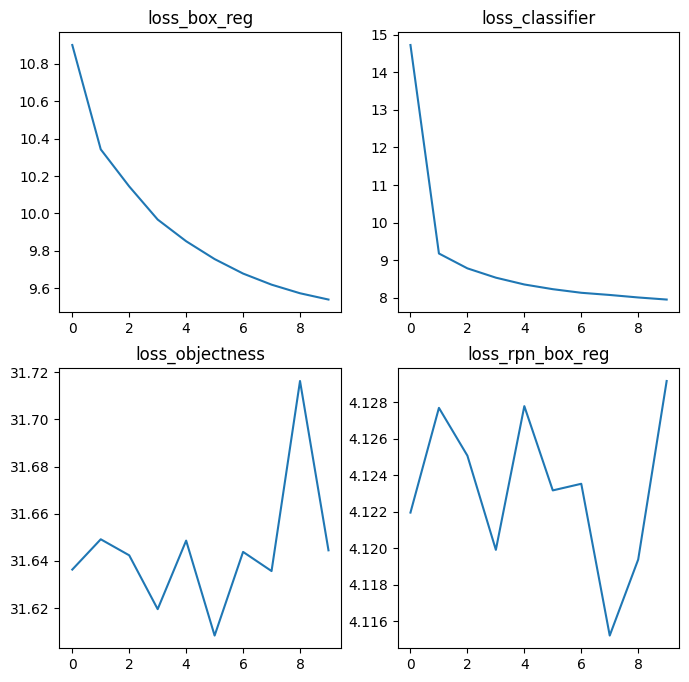

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (8,8))

epochs = len(results['loss_classifier'])

ax[0][0].plot(range(epochs),results['loss_box_reg'])
ax[0][0].set_title("loss_box_reg")

ax[0][1].plot(range(epochs),results['loss_classifier'])
ax[0][1].set_title("loss_classifier")

ax[1][0].plot(range(epochs),results['loss_objectness'])
ax[1][0].set_title("loss_objectness")

ax[1][1].plot(range(epochs),results['loss_rpn_box_reg'])
ax[1][1].set_title("loss_rpn_box_reg")


## Prediction

In [58]:
object_detection_model.eval()
with torch.inference_mode():

  images_test, labels_test = next(iter(test_object_detection_dataloader))

  images_test = [image.to(device) for image in images_test]
  for label in labels_test:
    label["boxes"] = label["boxes"].to(device)
    label["labels"] = label["labels"].to(device)

  prediction = object_detection_model(images_test)

prediction

[{'boxes': tensor([[ 25.4277,  21.1127, 204.0455, 214.5014],
          [ 88.9279, 104.0686, 206.4453, 215.2834],
          [ 18.8533,  68.0108,  51.9987, 120.3047],
          [134.3400, 124.6758, 211.1133, 198.9439],
          [147.2713,  74.0339, 211.2295, 142.2541],
          [179.3541, 177.1978, 224.0000, 223.3848],
          [ 37.9346,  84.8325, 174.9314, 222.8007],
          [ 97.1097,  15.3885, 209.5041, 145.0737],
          [165.6985,  94.5026, 221.3390, 167.6971],
          [152.0387,  54.7737, 224.0000, 192.9219]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.7503, 0.4737, 0.4029, 0.3433, 0.3363, 0.3304, 0.3173, 0.3081, 0.2843,
          0.2795], device='cuda:0')},
 {'boxes': tensor([[ 14.2816,  16.9069, 206.3795, 205.0592],
          [ 65.2671,  55.1006, 100.2240,  87.7784],
          [ 39.7874,  86.1253, 184.2212, 224.0000],
          [135.9615,  43.8951, 222.9105, 197.1637],
          [140.0881,  33.6976, 160.1

### Plot Predictions

In [59]:
labels_test[0]['boxes']

tensor([[ 14.,  66.,  56., 117.],
        [165.,  72., 195., 107.],
        [158., 134., 223., 218.]], device='cuda:0')

In [60]:
len(prediction[0]['boxes'])

10

In [61]:
keeps = ops.nms(boxes=prediction[0]['boxes'], scores=prediction[0]['scores'], iou_threshold=0.3)
keeps

tensor([0, 2, 3, 4, 5], device='cuda:0')

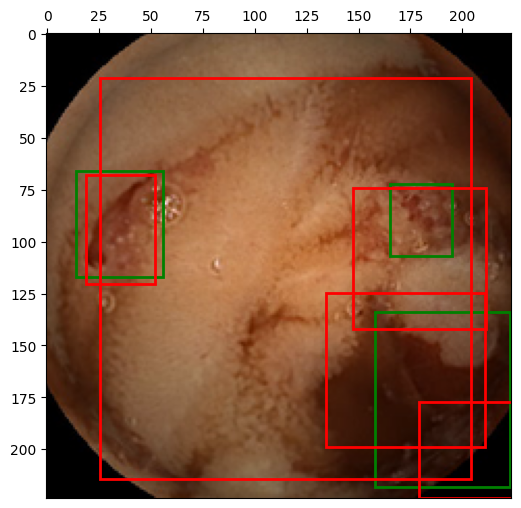

In [62]:
# for One image :

fig, ax = plt.subplots(figsize = (6,9))
ax.xaxis.tick_top()
ax.imshow(images_test[0].permute(1,2,0).cpu())

for box in labels_test[0]['boxes']:

  x1,y1,x2,y2 = box.cpu()

  w = x2 - x1
  h = y2 - y1

  ax.add_patch(patches.Rectangle((x1,y1),w,h, fill=False, edgecolor='green', lw=2))

# for index, predicted_box in enumerate(prediction[0]['boxes']):

for box_idx in keeps:

    x1,y1,x2,y2 = prediction[0]['boxes'][box_idx].cpu()

    w = x2 - x1
    h = y2 - y1

    ax.add_patch(patches.Rectangle((x1,y1),w,h, fill=False, edgecolor='red', lw=2))


In [63]:
def prediction_plot(model ,test_dataloader : DataLoader, device, batch_size : int, iou_threshould : float) -> None:

  model.eval()
  with torch.inference_mode():

    images, labels = next(iter(test_dataloader))

    images = [image.to(device) for image in images]
    for label in labels:
      label["boxes"] = label["boxes"].to(device)
      label["labels"] = label["labels"].to(device)

    prediction = model(images)

  fig, ax = plt.subplots(nrows=batch_size, ncols=1, figsize = (20,5*batch_size))
  index = 0

  for image, label, prediction_label in zip(images,labels,prediction):

    # plt.subplot(4,4,index+1)
    ax[index].imshow(image.permute(1,2,0).cpu())

    for box in label['boxes']:

      x1,y1,x2,y2 = box.cpu()

      w = x2 - x1
      h = y2 - y1

      ax[index].add_patch(patches.Rectangle((x1,y1),w,h, fill=False, edgecolor='green', lw=2))

    keeps = ops.nms(boxes=prediction_label['boxes'], scores=prediction_label['scores'], iou_threshold=iou_threshould)

    for box_idx in keeps:

      x1,y1,x2,y2 = prediction_label['boxes'][box_idx].cpu()

      w = x2 - x1
      h = y2 - y1

      ax[index].add_patch(patches.Rectangle((x1,y1),w,h, fill=False, edgecolor='red', lw=2))


    # ax[index].axis(False)
    index+=1

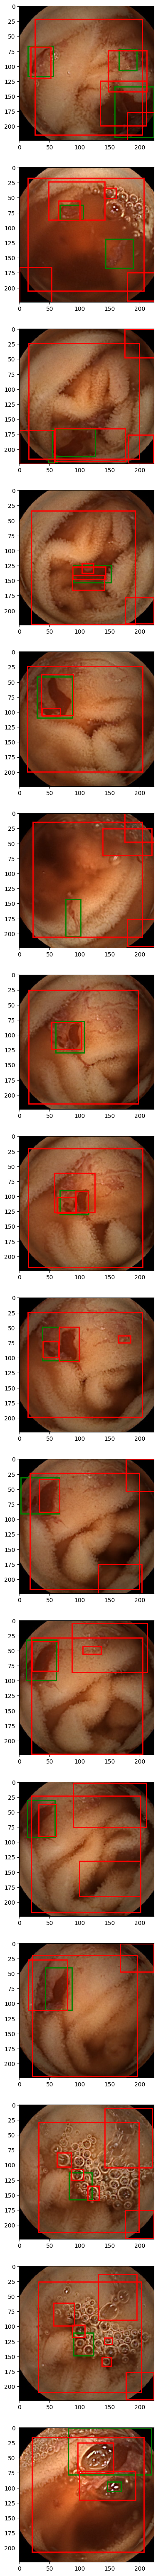

In [64]:
prediction_plot(model = object_detection_model,
                test_dataloader = test_object_detection_dataloader,
                device = device,
                batch_size = 16,
                iou_threshould = 0.2)

### Validation Dataset Prediction

In [65]:
validation_set_1 = pd.read_excel("/content/drive/MyDrive/Object detection data/Auto-WCEBleedGen Challenge Test Dataset/Test 1 Dataset.xlsx")
validation_set_1

,Unnamed: 0,Image name,Predicted Class label
0,0,A0008,non-bleeding
1,1,A0005,non-bleeding
2,2,A0004,non-bleeding
3,3,A0007,non-bleeding
4,4,A0010,non-bleeding
5,5,A0012,non-bleeding
6,6,A0013,non-bleeding
7,7,A0016,non-bleeding
8,8,A0002,bleeding
9,9,A0001,non-bleeding


In [66]:
validation_set_1.loc[validation_set_1['Predicted Class label']=='bleeding']

,Unnamed: 0,Image name,Predicted Class label
8,8,A0002,bleeding
15,15,A0000,bleeding
19,19,A0034,bleeding
20,20,A0044,bleeding
22,22,A0037,bleeding
27,27,A0043,bleeding
34,34,A0047,bleeding
35,35,A0031,bleeding
38,38,A0040,bleeding
39,39,A0039,bleeding


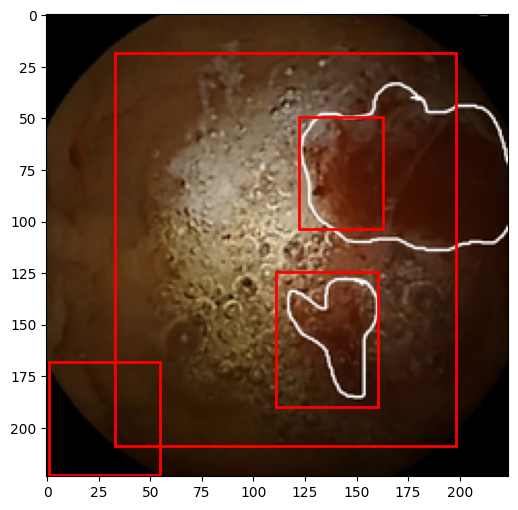

In [85]:
img_path = list(validation_test_1_path.glob(f"A0040.png"))

validation_img = transform(Image.open(img_path[0]))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (6,6))
plt.imshow(validation_img.permute(1,2,0))

object_detection_model.eval()
with torch.inference_mode():

  validation_prediction = object_detection_model(validation_img.unsqueeze(dim=0).to(device))
  keeps = ops.nms(boxes=validation_prediction[0]['boxes'], scores=validation_prediction[0]['scores'], iou_threshold=0.15)

  for box_idx in keeps:

    x1,y1,x2,y2 = validation_prediction[0]['boxes'][box_idx].cpu()

    w = x2 - x1
    h = y2 - y1

    ax.add_patch(patches.Rectangle((x1,y1),w,h, fill=False, edgecolor='red', lw=2))
